# Week 3: representational similarity analysis (RSA)

This week's tutorial is about RSA! We'll be looking at how to transform patterns into RDMs using various distance measures, how to test the relation between feature-RDMs and brain-RDMs, and take a look at exploratory RDM visualization using multidimensional-scaling (MDS).

We will use data from the SharedStates dataset - a within-subject dataset used previously for a cross-decoding analysis (see [here](https://github.com/lukassnoek/SharedStates/blob/master/sharedstates_fullarticle_draft.pdf) for a draft of the corresponding article, which is currently in press). In the first couple of examples of this tutorial, we'll use the single-trial pattern estimates from the "self-task", in which subjects were shown short sentences about either emotional actions ("action" trials), emotional ("interoceptive") feelings ("interoception" trials), or emotional situations ("situation" trials). They were instructed to imagine as if they were experiencing/doing the actions/feelings/situations themselves (see figure below). <img src='self_task.png'>

The self-task was done twice (i.e. in two runs). Each run contained 20 trials of each condition (action, interoception, situation), so in total (across runs) we have 120 trials (20 trials \* 3 conditions \* 2 runs). While we applied a (cross-)decoding analysis on this dataset for the original study, we will apply some RSA techniques on this data for this week's tutorial. (The SharedStates dataset is, by the way, also one of the data-sets that you can use for your final project (more info on Blackboard/Week 4)).

In terms of skills, after this tutorial you are be able to:

* Create representational dissimilarity matrices (RDMs) from brain patterns using various metrics;
* Create custom "conceptual" feature-RDMs based on categorical conditions;
* Statistically test the similarity between feature- and brain-RDMS;
* Exploratively visualize brain-RDMs with [MDS](http://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html);

### Names
student 1: fill in your name ...

student 2: ... and the name of the person you're working with

In [36]:
# Some imports for the rest of the tutorial
import os.path as op
from glob import glob
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Loading in and organizing data (yet again ...)
The SharedStates dataset is stored in the `/home/Public` folder again. Check out the folder (`/home/Public/SharedStates`) and its subfolders. You should see two directories - "SELF" and "OTHER" - which refer to the two tasks of the experiment. For the first part of the tutorial, you will work with data from the SELF task. Check out this directory: it should list several subdirectories referring to data from different subjects. Each subject contains two feat-directories referring to the two runs of the self-task. 

Let's check out the data from run 1 (`self1.feat`) for subject 3 (`sub003`). Look at the `design.png` file and make sure you understand the single-trial design. The `stats` directory contains the `tstat`-files corresponding to the single-trial-against-baseline contrasts. We want to load in these 60 files (\* 2, because there are two runs). 

<div class='alert alert-warning'>
**ToDo**: use `glob` to find *all* the tstat-paths belonging to *both* the runs from subject 3. So, you should find 120 paths. Hint: you need two wildcards.
</div>

In [4]:
paths = glob('/home/lukas/PatternAnalysis/week_4/SharedStatesData/SELF/sub003/*.feat/stats/tstat*.nii.gz')

# We'll sort the paths for you so that it is ordered *tstat1.nii.gz (run1), *tstat1.nii.gz (run2), *tstat2.nii.gz (run1) etc
paths = sorted(paths, key=lambda x: int(op.basename(x).split('.')[0].split('tstat')[-1]))

Below, we copied the Mvp-class from last week (we took the one we put in the solutions, but you may also copy your own if you want!). 

In [5]:

class Mvp():
    """ Custom class to load, organize, and process multivoxel MRI patterns. """
    
    def __init__(self, paths):
        
        self.paths = paths
        
    def load(self, voxel_dims=(91, 109, 91)):
        
        X = np.zeros((len(self.paths), np.prod(voxel_dims)))

        for i, path in enumerate(self.paths):
    
            X[i, :] = nib.load(path).get_data().ravel()
        
        self.X = X
    
    def standardize(self):
        self.X = (self.X - self.X.mean(axis=0)) / self.X.std(axis=0)
        # Because the above line may divide by 0 for voxels outside the brain,
        # this leads to NaN (Not a Number) values. The line below sets all NaN values to 0.
        self.X[np.isnan(self.X)] = 0
        
    def apply_mask(self, path_to_mask, threshold):
        
        mask = nib.load(path_to_mask).get_data()
        mask_bool = mask > threshold
        self.X = self.X[:, mask_bool.ravel()]

<div class='alert alert-warning'>
**ToDo**: initialize an Mvp-object below with the paths you globbed in the previous ToDo. Name the object `sub003`. Then, load the paths (call the method load()). Note that the voxel-dimensions are 80\*80\*37 here (i.e. in native EPI space, not standard MNI space). Do **not** standardize it and do not apply a mask.
</div>

In [84]:
# initialize the Mvp-object (and name it sub003)
sub003 = Mvp(paths=paths)
sub003.load(voxel_dims=(80, 80, 37))

### A note about standardization
Last week, you learned that you *need* to standardize your patterns (i.e. subtract the mean across samples and divide by the standard deviation across samples for all features (i.e. voxels) when we're working with ML algorithms. 

For RSA, however, you **shouldn't** standardize your patterns! It turns out that standardizing features leads to spurious (often negative) correlations between samples or conditions, which is of course detrimental for RSA. The reason for this is beyond the scope of this course (but see [this article](http://journal.frontiersin.org/article/10.3389/fnins.2013.00174/full) if you want to understand why this happens), but we thought you should know! 

## 2. Creating a 'conceptual model' RDM
In this section, we'll create a very simple 'conceptual model' RDM using the three conditions (action, interoception, situation) from the self-task. This conceptual model corresponds to the hypothesis that the distance between trials of the same condition are 0 and the distance between trials of different conditions is 1. If organized in a representational dissimilarity matrix (RDM), this would look like: <img src='conceptual_model.png'>

Importantly, we do not really use "world features" here, but we specify the RDM directly (therefore, it is called a "conceptual" RDM). So, we're not "creating" a (feature-)RDM based on features, but based on an assumed (hypothesized) geometry. Later in the tutorial, we'll also test a computational model in which we *do* need to build a feature-RDM based on "world features" (instead of assuming a specific geometry).

But to create such a conceptual model RDM, we need to know to which condition (action, interoception, situation) each sample (trial) in our `Mvp` object belongs. One way is to manually write it down, given that you know which tstat-file belongs to which condition, like this:

`conditions = ['action', 'action', 'interoception', 'interoception', 'situation', 'situation', etc]`

If you have to do this for every subject, though, it becomes annoying and error-prone! Fortunately, there is also a "programmatic" way to do this. FSL in fact outputs a file called `design.con` when creating a `feat`-directory which lists the names you gave to the single-trial-against-baseline contrasts.

<div class='alert alert-warning'>
    **ToDo**: Check out the `design.con` file in the feat-directory of run1 (`self1.feat`) for subject 3 (just double-click the file, this will open the file in a text-editor). 
</div>

Although weirdly structured, you can see that the `design.con` file lists all the contrast-names, i.e. `actie_1`, `actie_2`, `interoception_1`, etc. (I accidentally used `actie`, the Dutch word for `action`). We have extracted the conditions for all the contrasts (single-trial estimates) for both runs for you already, which we stored in a text-file called `sample_labels.txt`. Below, we load in this file (and convert the list with strings to a numpy-array with strings):

In [32]:
labels = np.loadtxt('/home/lukas/PatternAnalysis/week_4/SharedStatesData/SELF/sub003/sample_labels.txt',
                    dtype=str)
labels = np.array(labels)
print(labels)

['Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie'
 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie'
 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie'
 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie' 'Actie'
 'Actie' 'Actie' 'Actie' 'Actie' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Interoception' 'Interoception'
 'Interoception' 'Interoception' 'Situation' 'Situation' '

<div class='alert alert-warning'>
**ToDo**: Programming challenge! Given the vector with labels of length *N* (N = number of samples), can you make a conceptual model RDM of shape *N*\**N*, in which cells corresponding to the same condition should be 0 and cells corresponding to different conditions should be 1 (basically, just like the image above)? Try to write it in a function - `make_conceptual_rdm(labels)` - that takes one argument (`labels`, a vector of length *N*) and returns an *N*\**N* RDM-matrix (a numpy array).<br><br>

**Note**: Do not assume that the labels are ordered (like it is now)! It should also work for vectors like `['A', 'A', 'B', 'C', 'B', 'A', 'B', etc]`<br>
**Hint**: it involves (at least) one for-loop.<br>
**Note**: This is meant as a programming exercise. Don't spend too much time on it! If you can't figure it out, you can use the function we have written, which is contained in `functions.py` (`from functions import solution_make_conceptual_rdm`).
</div>

In [42]:
def make_conceptual_rdm(y):
    rdm = np.vstack([y != y_tmp for y_tmp in y])
    return rdm.astype(int)

    # implement it here!    

If you want to test your function, run the cell below! It also visualizes your RDM and how the RDM should look like!

Your RDM is correct!


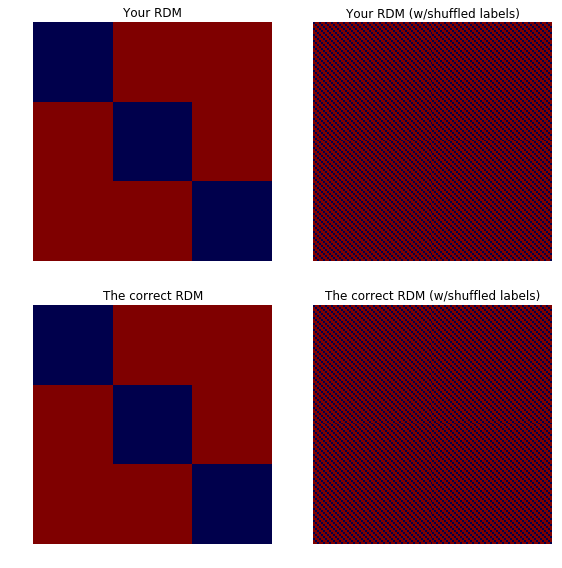

In [81]:
your_rdm = make_conceptual_rdm(labels)

# First check whether it really contains numbers (0 for same, 1 for different conditions)
assert(your_rdm.dtype != bool)

solution_rdm = np.load('solution_rdm.npy')

plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.title('Your RDM')
plt.imshow(your_rdm, cmap='seismic')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.title('The correct RDM')
plt.imshow(solution_rdm, cmap='seismic')
plt.axis('off')

# Check whether it is truly the same as the correct RDM
assert(np.sum(your_rdm == solution_rdm) == your_rdm.size)
print('Your RDM is correct!')

lab_shuf = [['actie', 'interoception', 'situation'] for i in range(40)]
lab_shuf = np.array([item for sublist in lab_shuf for item in sublist])

your_rdm_shuffled = make_conceptual_rdm(lab_shuf)
plt.subplot(2, 2, 2)
plt.title('Your RDM (w/shuffled labels)')
plt.imshow(your_rdm_shuffled, cmap='seismic')
plt.axis('off')

np.save('solution_shuffled_rdm.npy', rdm_shuf)
solution_shuffled_rdm = np.load('solution_shuffled_rdm.npy')

plt.subplot(2, 2, 4)
plt.title('The correct RDM (w/shuffled labels)')
plt.imshow(solution_shuffled_rdm, cmap='seismic')
plt.axis('off')
plt.tight_layout()
plt.show()

## 3. Creating your brain-RDM
While you specify your conceptual RDM directly, brain-RDMs have to be constructed by calculating distances between samples (in terms of their patterns in K-dimensional space). Therefore, when constructing brain-RDMs, you need to decide which distance metric you want to use. There are *very many* possible metrics (like correlation-distance, euclidean distance, mahalanobis distance, cityblock distance, etc. etc.), each with its own specific way of calculating distances, but fortunately they often yield very similar RDMs. 

Practically, calculating pairwise differences (i.e. sample 1 vs. sample 2, sample 1 vs. sample 3, etc. etc.) is quite tricky to implement (efficiently), as it involves N\*(N-1) pairwise distance calculations. Luckily, scikit-learn has a module that contains the function `pairwise_distances` ([link](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html#sklearn.metrics.pairwise.pairwise_distances)) that does exactly what we want: it takes a samples-by-feature matrix and transforms it into a samples-by-samples (i.e. N\*N) distance matrix, the *RDM*.

<div class='alert alert-warning'>
**ToDo**: Below, we import the pairwise_distances function. Check out the documentation (click the link in the above text-block). Now, in the code-block below, call the pairwise_distances function with `sub003.X` as input and metric set to 'euclidean'. Store the result in a variable named `brain_rdm`.
</div>

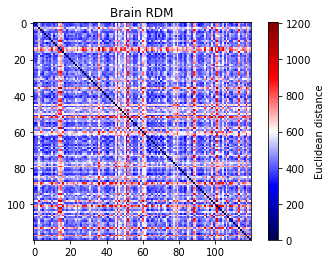

In [92]:
from sklearn.metrics.pairwise import pairwise_distances
brain_rdm = pairwise_distances(sub003.X)

Now, we can visualize RDMs using matplotlib's `imshow()` function:

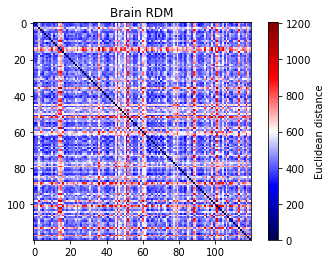

In [94]:
plt.title('Brain RDM')
plt.imshow(rdm, cmap='seismic')
plt.colorbar(label='Euclidean distance')
plt.show()

<div class='alert alert-info'>
**ToDo**: we just calculated and visualized an RDM based upon the Euclidean distance, but as discussed, there are many others. Below, we created a list with different metrics. Create a loop over these metrics, in which you create a new RDM using the corresponding metric and visualize it using `plt.imshow()` across 5 different subplots.  
</div>

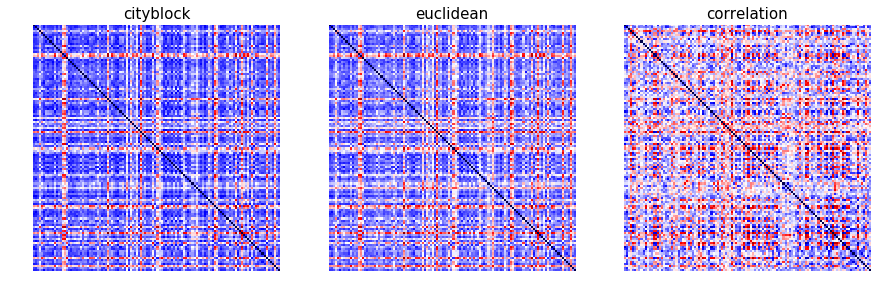

In [102]:
metrics = ['cityblock', 'euclidean', 'correlation']

plt.figure(figsize=(15, 15))

# Start your loop over metrics here (this may take a while!)
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    rdm = pairwise_distances(sub003.X, metric=metric)
    plt.title(metric, fontsize=15)
    plt.imshow(rdm, cmap='seismic')
    plt.axis('off')

plt.show()

<div class='alert alert-info'>
**(Advanced!) ToThink**: In the 3 subplots above, you clearly see that the `correlation` RDM is qualitatively different than the others (`cityblock` and `euclidean`). There is one factor that drives this difference. Can you figure out what this factor is? <br><br>

Hint 1: check out the formulas for the correlation distance and the euclidean distance between two vectors ("patterns") $p$ and $q$ which are of length $K$ (the amount of features/voxels), and have means $\bar{p}$ and $\bar{q}$:<br><br>

\begin{align}
\delta_{euclidean} = \sqrt{\sum_{i=1}^{K}{(p_{i} - q_{i})^{2}}}
\end{align}<br>


\begin{align}
\delta_{correlation} = 1-\frac{\sum_{i=1}^{K}((p_{i} - \bar{p})\cdot(q_{i} - \bar{q}))}{\sqrt{\sum_{i=1}^{K}{((p_{i} - \bar{p})^{2}\cdot(q_{i} - \bar{q})^{2})}}}
\end{align}

</div>

Alright, so now we got two RDMs: the conceptual model RDM (often called feature-RDM, or candidate-RDM) and the brain-RDM. To test whether our model (the conceptual model RDM) significantly explains our brain-RDM, we only have to correlate them, as depicted below:

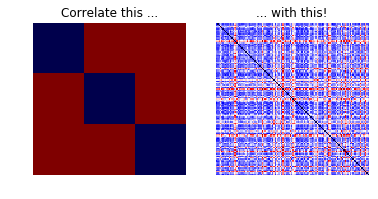

In [95]:
plt.subplot(1, 2, 1)
conc_rdm = np.load('solution_rdm.npy')
plt.title('Correlate this ...')
plt.imshow(conc_rdm, cmap='seismic')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('... with this!')
plt.imshow(rdm, cmap='seismic')
plt.axis('off')
plt.show()

In [68]:
import pandas as pd
def extract_contrast_names(design_file):
    
    contrasts = np.sum([1 if 'ContrastName' in line else 0
                        for line in open(design_file)])

    n_lines = np.sum([1 for line in open(design_file)])

    df = pd.read_csv(design_file, delimiter='\t', header=None,
                     skipfooter=n_lines - contrasts, engine='python')

    cope_labels = list(df[1].str.strip())  # remove spaces
    cope_labels = ["_".join(c.split('_')[:-1]) if c.split('_')[-1].isdigit()
                   else c for c in cope_labels]
    return cope_labels
    
def generate_categorical_rdm(y):
    rdm = np.vstack([y != y_tmp for y_tmp in y])
    return rdm.astype(int)

def kendalltau_a(a, b):
    
    n = a.size
    K = 0
    for k in range(n - 1):
        pairrel_a=np.sign(a[k]-a[k+1:n])
        pairrel_b=np.sign(b[k]-b[k+1:n])
        K += np.sum(pairrel_a * pairrel_b)
    return K/(n*(n-1) / 2.0)

def test_rdm(X, candidate_rdm, dist_func, corr_func, average=False, mask=None):
    
    if average:
        X = (X[::2, :] + X[1::2, :]) / 2.0
        candidate_rdm = candidate_rdm[::2, ::2]
    
    if mask is not None:
        X = X[:, mask]
    
    brain_rdm = pairwise_distances(mvp.X, metric=dist_func)
    brain_rdm = brain_rdm[np.triu_indices(brain_rdm.shape[0], k=1)]
    candidate_rdm = candidate_rdm[np.triu_indices(brain_rdm.shape[0], k=1)]
    score = corr_func(brain_rdm, candidate_rdm) 
    
    if isinstance(score, (list, tuple)):
        score = score[0]
    return score

In [3]:
from glob import glob
from skbold.utils import load_roi_mask, parse_roi_labels
import os.path as op

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import pairwise_distances
import pandas as pd
from scipy import stats

/home/lukas/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/lukas/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [ ]:
lud = {'Actie': 0,
       'Interoception': 1,
       'Situation': 2}
mask_names = sorted(parse_roi_labels(atlas_type='HarvardOxford-Cortical', lateralized=True).keys())
subs = sorted(glob('/media/lukas/data/PatternAnalysis/week_4/SharedStatesData/SELF/sub*'))

scores = np.zeros((len(subs), len(mask_names)))

for i, sub_path in enumerate(subs):
    sub = op.basename(sub_path)
    print(sub)
    reg_dir = sub_path + '/%s-self1.feat/reg' % sub
    path = sub_path + '/*.feat/stats/tstat*.nii.gz'
    paths = sorted(glob(path), key=lambda x: int(op.basename(x).split('.')[0].split('tstat')[-1]))
    labels = extract_condition_names(sub_path + '/%s-self1.feat/design.con' % sub)
    labels.extend(labels)
    labels = sorted(labels)
    labels = np.array([lud[tmp] for tmp in labels])
    cat_rdm = generate_categorical_rdm(labels)

    masks = load_roi_mask('all', atlas_name='HarvardOxford-Cortical',
                          lateralized=True, threshold=0, reg_dir=reg_dir, which_hemifield='left')

    for ii, mask in enumerate(masks):
        mvp = Mvp(paths)
        mvp.load(voxel_dims=(80, 80, 37))
        mvp.X = mvp.X[:,mask.ravel()]
        mvp.X = (mvp.X[0::2, :] + mvp.X[1::2, :]) / 2.0
        brain_rdm = pairwise_distances(mvp.X, metric='correlation')
        brain_rdm_triu = brain_rdm[np.triu_indices(brain_rdm.shape[0], k=1)]
        cat_rdm_tmp = cat_rdm[::2]
        cat_rdm_triu = cat_rdm_tmp[np.triu_indices(brain_rdm.shape[0], k=1)]
        scores[i, ii] = stats.spearmanr(brain_rdm_triu, cat_rdm_triu)[0]
print(scores)

In [ ]:
mask_names[scores.mean(axis=0).argmax()]

In [ ]:
scores[:, 30]